# PCA: from newbie to ninja

In this PCA crash course, we're going to set the stage with a brief theoretical background on what PCA is and what it tries to do, and then we're going to jump right in and write our own implementation from scratch. 

### What I expect you to know:
- A bit of linear algebra (matrix multiplication, transpose)
- A bit of Python (Numpy, Matplotlib)


## Contents

### [Intro: PCA in one drawing](#pcadrawing)

### [Theoretical preliminaries](#theoreticalpreliminaries)
- [Minimizing the reconstruction error or minimizing the variance?](#minimizemaximize)
- [Finding the PCA components](#findingcomponents)
    
### [Coding PCA from scratch](#coding)
0. [Obtaining and visualizing the data](#obtainvisualize)
1. [Centering the data](#center)
2. [Constructing the covariance matrix](#covariancematrix)
3. [Computing the eigenvalues and eigenvectors of the covariance matrix](#eigen)
4. [Sorting the eigenvalues and choosing the eigenvectors](#sortingeigen)
5. [Projecting the data to PCA space](#projecting)

### [Outro](#outro)
- [Choosing the number of dimensions](#choosingdimesions)
- [Doing it the fast way](#thefastway)
    


<a id='pcadrawing' ></a>
# Intro: PCA in one drawing
When applying PCA, we aim to find a linear transformation $C$ which, applied to our data $X$, gives us a lower dimensional representation $W$ which captures most of the variance in the data (or alternatively minimizes the reconstruction error). That is, given a data matrix $X$ of dimension $n \times m$, we look for another matrix $C$ of dimensions $m \times q$ such that if we multiply $X$ by $C$ we get a matrix $W$ of size $n \times p$, with $p < m$ which captures as much of the information contained in $X$ as possible. Understanding PCA involves keeping track of some matrix multiplication logistics, which are summarized in the drawing below.

![title](images/PCA_matrices.svg)

As shown in the image above, we start with a data matrix $X$ in which the columns are the features (e.g. recorded neurons in a population) and the rows are samples (e.g. time points at which our signal is recorded). The reconstruction $\hat{X} = WC^T $ is then obtain by matrix multiplication of the loadings $W$ with the tranpose of the PCA components $C^T$. The loadings, as shown in the bottom part of the image, are the results of projecting the data matrix $X$ in space determined by the PCA components $C$, so when people talk about 'projecting the data in the lower dimensional space determined by the first $n$ PCA components', what they mean is packing the first $n$ PCA components in a matrix $C$ and computing the matrix multiplication $W = XC$. As a consequence of matrix multiplication, the resulting projected data $W$ will have as many dimensions (columns) as there are components in $C$, and as many samples (rows) as there are samples in $X$, and it is thus effectively a more compact representation of $X$.

<a id='theoreticalpreliminaries' ></a>
# Theoretical preliminaries

<a id='minimizemaximize' ></a>
## Minimizing the reconstruction error or maximizing the variance?

PCA can be formulated in __two equivalent ways__: minimizing the reconstruction error, or maximizing the variance (of the projected data). When we want to __minimize the reconstruction error__, we can write the PCA objective as:

\begin{align}
\underset{C}{\mathrm{minimize}} & \quad \left \Vert X - XCC^T \right \Vert ^2 _F \\
\mathrm{subject\,to} & \quad C^TC=I
\end{align}

Where $C^TC = I$ is a constraint imposing __orthogonality__ of the PCA components. 

Why is $\left \Vert X - XCC^T \right \Vert ^2 _F$ the reconstruction error? Remember that the projected data is given by $W=XC$. By multiplying $XC$ it by $C^T$ we are projecting it back to its original space, resulting in $\hat{X}=XCC^T$ (as you can see in the scheme above). The $\quad \left \Vert \cdot \right \Vert ^2 _F$ notation indicates that we take the square of the Frobenius norm (once we have computed the elementwise difference between $X$ and $XCC^T$, we sum all the squared elements of the resulting matrix).

In the process of reducing the dimensions of the data ($XC$) some information is almost inevitably going to get lost, such that when we reconstruct the data matrix of the same dimensionality ($\hat{X} = XCC^T$) our reconstruction $\hat{X}$ is going to be different from $X$: PCA tries to minimize this loss of information by ensuring that $\hat{X}$ is close to $X$, which in turn implies that the projection $W$ has retained as much of the information contained in $X$ as possible. 

An alternative yet equivalent formulation which is often found describes PCA as __maximizing the variance__ of the projected data. This means that we want our projection $W=XC$ to contain as much of the variability that was contained in our original data as possible. 

\begin{align}
\underset{C}{\mathrm{maximize}} & \quad \mathrm{tr} \left( C^T X^T X C\right) \\
\mathrm{subject\,to} & \quad C^TC=I
\end{align}

Why is $\mathrm{tr} \left( C^T X^T X C\right)$ the variance of the data?
Given a mean-centered matrix $X$ (where we have subtracted from every column the mean of that column) with $N$ rows, the covariance matrix is given by $S = \frac{1}{N-1}X^TX$. Since $W = XC$ is our projected data, the covariance matrix of the projected data is proportional to $W^TW$, or equivalently $C^T X^T X C$. In PCA what we minimize is actually the trace $\mathrm{tr} \left( C^T X^T X C\right)$ of the covariance matrix, which is the sum of all the diagonal elements. Basically, we minimize the sum of the variance in each dimension. 

### Why are minimizing the reconstruction error and maximizing the variance equivalent?

This point is nicely explained geometrically in this interesting [blog post](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/), and you can see a derivation [here](https://stats.stackexchange.com/questions/32174/pca-objective-function-what-is-the-connection-between-maximizing-variance-and-m). 

I'll quickly give you the geometric intuition (but if you're interested in understanding this in more detail, do check out the links above): the idea is that the variance that a single data point contributes is composed by the variance that the PCA reconstruction preserves, and the variance that it loses. Thus, you can maximize the variance kept, or minimize the variance lost, and this lost variance is in fact proportional to the reconstruction error. 

![title](images/PCA_maximize_minimize.svg)

<a id='findingcomponents' ></a>
## Finding the PCA components 
Once we know our objective, how do we find the linear transformation $C$ which maximizes the variance (or minimizes the reconstruction error)? It turns out that the components which make up $C$ are the __leading eigenvector of the covariance matrix__. 

At this point, this may sound a bit like magic. To show this, we would have to solve an optimization problem where we look for the set of unit vectors which maximize the variance of your data. We would then see that indeed the directions along which variance is maximized are the directions of the principal eigenvectors (the eigenvectors with the highest eigenvalues). This is quite handy, because computing eigenvalues and eigenvectors can be done quite rapidly, as we will see below. 

<a id='coding' ></a>
# Coding PCA from scratch

Let's go ahead and write our own PCA implementation! 

<a id='obtainvisualize' ></a>
## 0. Obtaining and visualizing the data
Let's begin by loading the classic Iris dataset, and taking a look at its content.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
import pandas as pd

df = sns.load_dataset("iris")

df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


To quickly have a look at the data, we can use Seaborn's pairplot, which plots all pairs of features against each other, together with the historgrams of each feature on the diagonal subplots. 

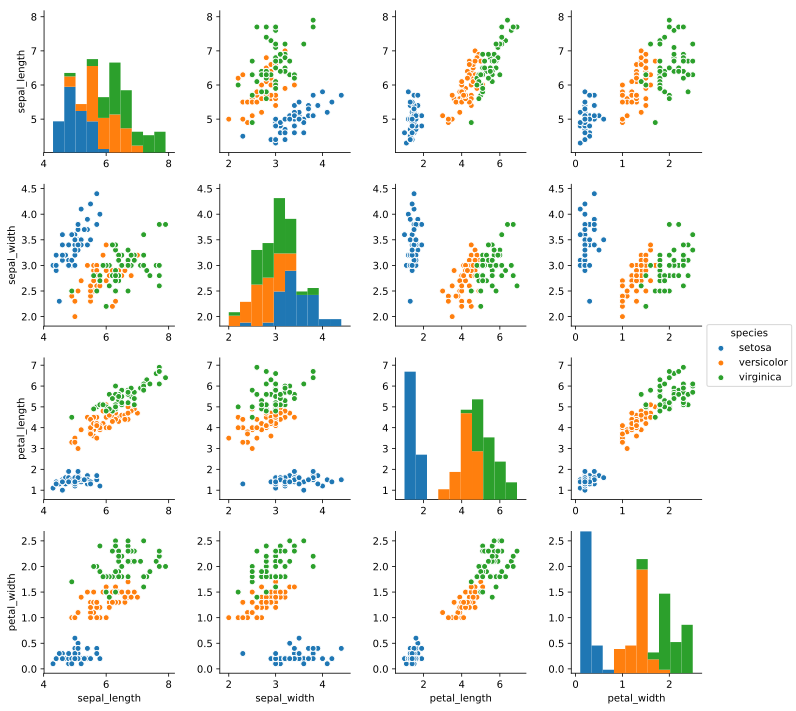

In [2]:
# <!-- collapse=False -->

f = sns.pairplot(df, hue="species")

Every sample in this dataset is a flower of one of three species, and the four features are the measured length and width of petals and sepals of each flower. Let's get rid of a few things we don't need, such as column names and index, and prepare our data for fitting PCA as a simple Numpy array `X`. We also extract the labels (species name) `y` which will come in handy for plotting.  

In [3]:
X = df.iloc[:,0:4].values
y = df.iloc[:,4].values

<a id='center' ></a>
## 1. Centering the data

The first step consists of standardizing the data, which means that we rescale each column (feature) of our data to have a mean of zero. 

In [4]:
X_mean = np.mean(X, axis=0)
X_std = (X - X_mean)
print(X_std.mean(axis=0))

[-3.31586610e-16 -3.55271368e-16 -6.63173220e-16 -2.36847579e-16]


<a id='covariancematrix' ></a>
## 2. Constructing the covariance matrix
Given our centered data matrix, which we call $X_s$, we can compute the covariance matrix simply by:

\begin{equation}
\Sigma = \frac{1}{n-1} X_s^T X_s
\end{equation}

Which in Numpy will be

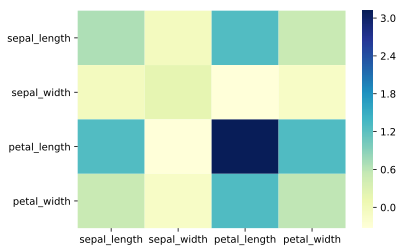

In [5]:
cov_mat = (X_std).T.dot(X_std) / (X_std.shape[0]-1)

# plot the covariance matrix
cols = df.columns[:-1]
f = sns.heatmap(cov_mat, xticklabels=cols, yticklabels=cols, cmap="YlGnBu")

Numpy also provides the handy `np.cov`, and we can check that it would give us the same result.

In [6]:
cov_mat_np = np.cov(X_std, rowvar=False)
np.testing.assert_almost_equal(cov_mat, cov_mat_np)

<a id='eigen' ></a>
## 3. Computing the eigenvalues and eigenvectors of the covariance matrix

To compute the eigenvalues and eigenvectors of our covariance matrix, we can use Numpy's eigendecomposition:

In [7]:
# compute eigendecomposition
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors: \n{}'.format(eig_vecs))
print('Eigenvalues: \n{}'.format(eig_vals))

Eigenvectors: 
[[ 0.36138659 -0.65658877 -0.58202985  0.31548719]
 [-0.08452251 -0.73016143  0.59791083 -0.3197231 ]
 [ 0.85667061  0.17337266  0.07623608 -0.47983899]
 [ 0.3582892   0.07548102  0.54583143  0.75365743]]
Eigenvalues: 
[4.22824171 0.24267075 0.0782095  0.02383509]


<a id='sortingeigen' ></a>
## 4. Sorting the eigenvalues and choosing the eigenvectors
As we mentioned earlier, the eigenvector which maximizes the variance is the one with the largest eigenvector, and the $q$ eigenvectors which maximize the variance are the ones with the $q$ largest eigenvalues, so we proceed to sorting our eigenvalues and select the corresponding eigenvectors. 

In [8]:
srt = np.argsort(eig_vals)[::-1] # indices of eigenvalues from largest to smallest
eig_vals_srtd = eig_vals[srt] # sorted eigenvalues
eig_vecs_srtd = eig_vecs[:, srt] # sorted eigenvectors
print('Sorted eigenvalues: \n{}'.format(eig_vals_srtd))
print('\nSorted eigenvectors: \n{}'.format(eig_vecs_srtd))

Sorted eigenvalues: 
[4.22824171 0.24267075 0.0782095  0.02383509]

Sorted eigenvectors: 
[[ 0.36138659 -0.65658877 -0.58202985  0.31548719]
 [-0.08452251 -0.73016143  0.59791083 -0.3197231 ]
 [ 0.85667061  0.17337266  0.07623608 -0.47983899]
 [ 0.3582892   0.07548102  0.54583143  0.75365743]]


We can compose our linear transformation by selecting the first two eigenvectors (later we will see how to make a more informed guess as to how many eigenvectors to pick).

In [9]:
C = eig_vecs_srtd[:, 0:2]
print(C)

[[ 0.36138659 -0.65658877]
 [-0.08452251 -0.73016143]
 [ 0.85667061  0.17337266]
 [ 0.3582892   0.07548102]]


<a id='projecting' ></a>
## 5. Projecting the data
Once we have our transformation $C$, we only need to multiply it with $X$: this will hand us the lower dimensional representation of our data. Since we chose the first two eigenvectors, we have obtained a two-dimensional representation of the original four-dimensional data, which is quite handy for visualization. A common way to show PCA-reduced data is by plotting the first component against the second:

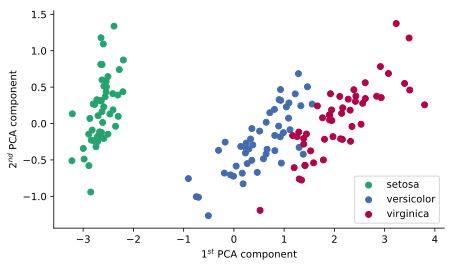

In [10]:
Xp = np.matmul(X_std, C)
species = ['setosa', 'versicolor', 'virginica']
colors  = ['teal green', 'french blue', 'raspberry']
f, ax = plt.subplots(1, 1, figsize=[7, 4])
for sp, c in zip(species, colors):
    ax.scatter(Xp[y==sp,0], -Xp[y==sp,1], c=sns.xkcd_rgb[c], label=sp)
l = ax.legend()
sns.despine(fig=f, top=True, right=True)
ax.set_xlabel('$1^{st}$ PCA component');
ax.set_ylabel('$2^{nd}$ PCA component');

As we can see, the data projected in the space of the first two components shows three clusters which are quite well separated from each other. At this point, it is useful to stop and think about the PCA components we have found. Let's look at the first component:

In [11]:
print(C[:, 0])

[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]


It is important to remember what these four numbers represent: this is a linear combination of the four features which identifies the direction of largest variance in feature space. Thus, it is interesting to inspect it to see how it 'uses' different features. In this case, we can see that the third feature (in this case petal length) has the largest value: this means that the most variance is along this feature. The first and last features (sepal length and petal width) enter the linear combination with a smaller weight, and lastly the second feature (sepal width) has the lowest weight. This means that, when projecting the data on the first PCA component, PCA mostly looks at petal length, then a bit at sepal length and petal width, and it almost doesn't consider sepal width (although later components may). PCA has essentially handed us a new feature, which is obtained by linearly combining the existing features using the weights given by the elements of the first component. 

To summarize, we could pack all of the steps above into a function which receives as input a data matrix `X` of shape `n_samples x n_features`, and the number of components we want to use, and returns the lower-dimensional projection.

In [12]:
def apply_PCA(X, n_components=2):
    X_std = X -  np.mean(X, axis=0) # 1. Center the data
    cov_mat = np.cov(X_std, rowvar=False) # 2. Compute the covariance matrix
    eig_vals, eig_vecs = np.linalg.eig(cov_mat) # 3. Eigenvectors and values of the cov. matrix
    srt = np.argsort(eig_vals)[::-1] # 4. Sort and choose the eigenvectors
    eig_vecs_srtd = eig_vecs[:, srt] 
    C = eig_vecs_srtd[:, 0:n_components] 
    Xp = np.matmul(X_std, C) # 5. Project the data
    return Xp

<a id='outro' ></a>
# Outro

<a id='choosingdimensions' ></a>
## Choosing the number of dimensions
A point we have not addressed so far is how to decide how many eigenvectors we should keep to form the linear transformation $C$. A common heuristic is to look at the variance or cumulative variance explained by each components. This is quite easy since the proportion of the variance explained by an eigenvector is given by its eigenvalue divided by the sum of all eigenvalues. Let's first make a plot!

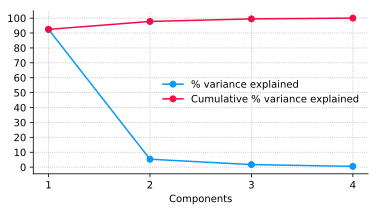

In [13]:
total_var = eig_vals_srtd.sum()
var_exp = [(v / total_var)*100 for v in eig_vals_srtd]
cumulative_var = [np.sum(var_exp[0:i]) for i in range(1, len(var_exp)+1)]

f, ax = plt.subplots(1, 1, figsize=[6,3])
ax.plot(range(len(var_exp)), var_exp,'-o', label='% variance explained', color=sns.xkcd_rgb["azure"])
ax.plot(range(len(var_exp)), cumulative_var,'-o', label='Cumulative % variance explained', c=sns.xkcd_rgb["pinkish red"])
ticks = ax.set_xticks(range(len(var_exp)))
tick_lab = ax.set_xticklabels(range(1, len(var_exp)+1))
yticks = ax.set_yticks(np.arange(0, 110, 10))
sns.despine(fig=f, right=True, top=True)
xlab = ax.set_xlabel('Components')
ax.grid(ls=':')
l = ax.legend(frameon=False)

Then, you can look for the famous _kink_ or _elbow_ in the scree plot of the variance, and pick the number of components at which the kink occurs, the rationale being that most of the variance will be accounted for by the components before the kink. 

Alternatively, you could pick a number of components such that a certain percentage of the variance in the original data is accounted for. In our case, with two components, we have accounted for more than 90% of the original variance, and adding a third component is probably not worth the added variance. 

<a id='thefastway' ></a>
## Doing it the fast way
In practice, if I had to run PCA on some data, I would not write my own function, but rather use the implementation provided by [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). At the core, this implementation is still subtracting the mean from each column and calling `np.linalg.svd` (an alternative to `np.linalg.eig`), but it provides a nice wrapper around it with a lot of handy features. To use it, we first have to instantiate a PCA object by calling the constructor, and then we can use the `fit_transform` method to both fit PCA and project our data.

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4) # Instantiate the PCA class, specifying the number of components we want
Xp = pca.fit_transform(X) # Done! Xp is the lower dimensional representation of our data

We can access the PCA components that we just found as easiy as

In [15]:
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143],
       [-0.31548719,  0.3197231 ,  0.47983899, -0.75365743]])

Although note earlier we talked about the matrix $C$ having dimensions $m \times q$, that is $\# \mathrm{features}\times \# \mathrm{components}$, whereas `pca.components_` has dimensions $\# \mathrm{components}\times \# \mathrm{features}$.

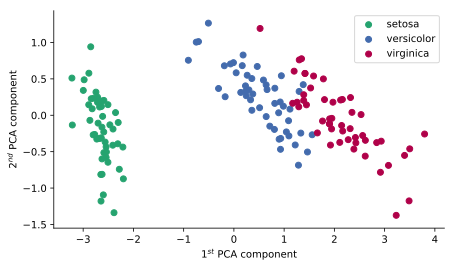

In [16]:
species = ['setosa', 'versicolor', 'virginica']
colors  = ['teal green', 'french blue', 'raspberry']
f, ax = plt.subplots(1, 1, figsize=[7, 4])
for sp, c in zip(species, colors):
    ax.scatter(Xp[y==sp,0], -Xp[y==sp,1], c=sns.xkcd_rgb[c], label=sp)
l = ax.legend()
sns.despine(fig=f, top=True, right=True)
ax.set_xlabel('$1^{st}$ PCA component');
ax.set_ylabel('$2^{nd}$ PCA component');

As you may have noticed, this image is not quite identical to the one we made before. In fact, the sign of the second component is flipped. Don't panic though, this is totally fine: the direction of the eigenvectors (i.e. which side they point to) is essentially arbitrary, so it is possible that using different software will result in flipped components. What we care about is the direction of maximal variance, not whether we go one way or the other along that direction. 

A nice perk of using Scikit-learn's PCA is that we can set the `n_components` parameter to a float between 0 and 1 representing the percentage of variance that we want to capture with our PCA decomposition. Setting `n_components=0.9` is equivalent to choosing the number of components such that 90% of the variance in our original data is explained.

In [17]:
pca = PCA(n_components=0.9) 
Xp = pca.fit_transform(X)
print('Number of components which explain 90% of the variance: {}'.format(Xp.shape[1]))

pca = PCA(n_components=0.95) 
Xp = pca.fit_transform(X)
print('Number of components which explain 95% of the variance: {}'.format(Xp.shape[1]))

Number of components which explain 90% of the variance: 1
Number of components which explain 95% of the variance: 2


We can see that this of course matches with what we knew from our plot of the cumulative variance explained! We also have the option of selecting the number of components using [Minka's Bayesian model selection method](http://hd.media.mit.edu/tech-reports/TR-514.pdf), which looks for the 'true' underlying dimensionality of the data. Finding the true underlying dimensionality of data is a very interesting and not at all trivial topic, so I will not go into here, but perhaps in a future tutorial. 

In [18]:
pca = PCA(n_components='mle') 
Xp = pca.fit_transform(X)
print('Number of components chosen with Minka\'s MLE estimation: {}'.format(Xp.shape[1]))

Number of components chosen with Minka's MLE estimation: 3
